In [39]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp

In [90]:
#Number of simulation
n=319

#choose between 'local' or 'dahu'
where='dahu'


#Reading the netcdf file


if where=='local':
    if n<10:
        simu_name='outdir_000'+str(n)
    elif n<100 and n>=10:
        simu_name='outdir_00'+str(n)
    Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

elif where=='dahu':
    simu_name='dahu_'+str(n)
    Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()
print('la simulation chargée est: ' + simu_name )
print("depuis: "+where)

filenames=['/vars.nc']



dataset=nc.Dataset(Path+filenames[0])
print(dataset.variables.keys())

t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,:,:,:]
q=dataset.variables['q'][:,:,:,:]

print("psi shape",psi.shape)
#Lecture des paramètres :

param=io.read_params(Path)
print(param)
f0= param['f0']
beta=param['beta']
hEkb=param['hEkb']
dh=param['dh'][0]
Lx=param['Lx']
nx=param['NX']
ny=param['NY']
k_f=param['k_f']
sigma_f=param['sigma_f']
bc_fac=param['bc_fac']
nu_hyper=param['nu_hyper']
n_hyper=param['n_hyper']
dt_out=param['dt_out']

la simulation chargée est: dahu_319
depuis: dahu
dict_keys(['time', 'y', 'x', 'level', 'psi', 'q'])
psi shape (150, 1, 2049, 2049)
{'NX': 2048.0, 'NY': 2048.0, 'nl': 1.0, 'Lx': 502.65482457, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00077160493827, 'n_hyper': 4.0, 'hEkb': 0.00390625, 'tend': 1576800000000.0, 'dt_out': 10.0}


(30, 2049, 2049)
Error = 1.5460399999999999 %
Energy_diss_drag/Energy_injected 90.843 %


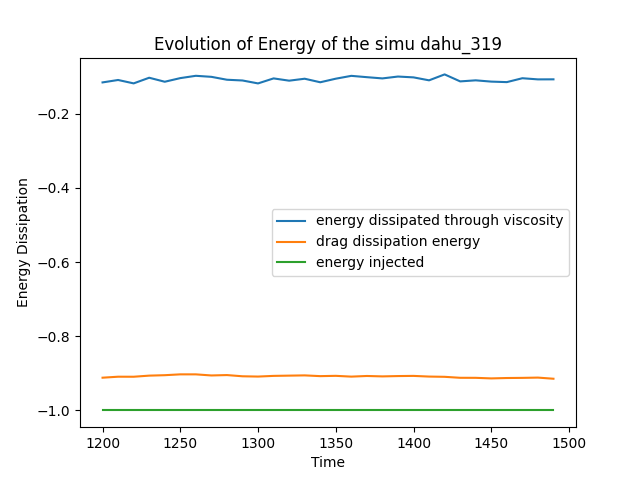

In [91]:
time_start =30
psi_data = psi[-time_start:, 0, :, :]
q_data = q[-time_start:, 0, :, :]

dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]

Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain

#Calculating the energy
energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
print(np.shape(enstro))
enstro_mean=np.mean(enstro,axis=(1,2))
#Calculating the total enstrophy for each snapshots
enstro_tot=np.sum(enstro,axis=(1,2))


dx=x[-1]/x.shape[0]
r=f0*hEkb/(dh*2)


#energy injectée :
energy_inj=np.zeros_like(energy_totale)
energy_inj[:]=sigma_f**2
energy_diss=-2*energy_totale*r
#enstro_diss=-2*nu_hyper*enstro_mean

#Calculating the enerrgy dissipated by hyper-viscosity
lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)

if n_hyper==6:
    #palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
    palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
    enstro_diss=-nu_hyper*palenstro_tot 

#Dans le cas ou l'hyper visocisté est égale à 4:
elif n_hyper==4:    

    enstro_diss=nu_hyper*np.mean(lap_vorticity*q_data,axis=(1,2))

mean_enstro_diss=np.mean(enstro_diss[:])
mean_energy_diss=np.mean(energy_diss[:])
mean_energy_inj=np.mean(energy_inj[:])

#computing the error of the energy dissipation
print("Error =",round(-mean_energy_diss-mean_enstro_diss-mean_energy_inj,7)/mean_energy_inj*100,'%')


ratioE=mean_energy_diss/mean_energy_inj*100
print("Energy_diss_drag/Energy_injected",-round(ratioE,3),'%')

plt.figure()

plt.plot(t[-time_start:],enstro_diss,label='energy dissipated through viscosity')
plt.plot(t[-time_start:],energy_diss,label='drag dissipation energy')
plt.plot(t[-time_start:],-energy_inj,label='energy injected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Dissipation')
plt.title('Evolution of Energy of the simu '+str(simu_name))
#plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
plt.show()


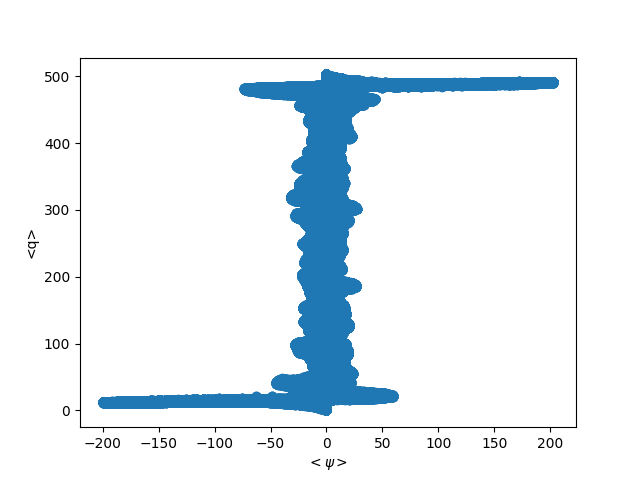

In [95]:
#We plot the mean streamfunction  and the mean q
startt=0

q_mean = np.mean(q[startt:,0,:,:],axis=0)
psi_mean= np.mean(psi[startt:,0,:,:],axis=0)
X,Y=np.meshgrid(x,y)

plt.figure()
plt.scatter(psi_mean,q_mean+beta*Y)
plt.xlabel(r'$<\psi>$')
plt.ylabel('<q>')
plt.show()




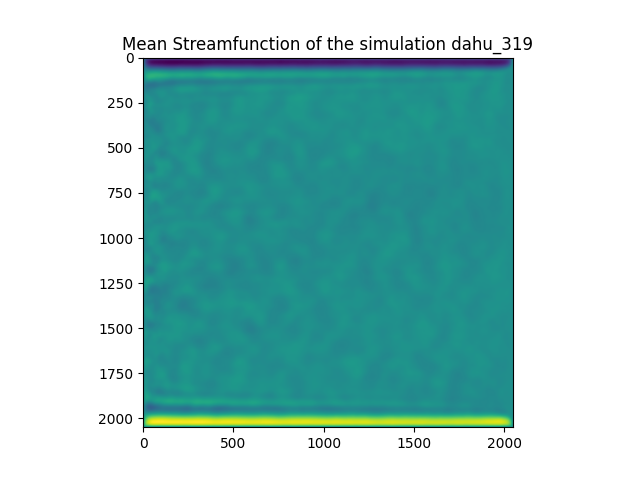

In [99]:
plt.figure()
plt.imshow(psi_mean,vmax=np.max(psi_mean))#+beta*Y)
plt.title('Mean Streamfunction of the simulation '+str(simu_name))
plt.savefig('./figures/jets/psi_mean_'+str(simu_name)+'.png')
plt.show()


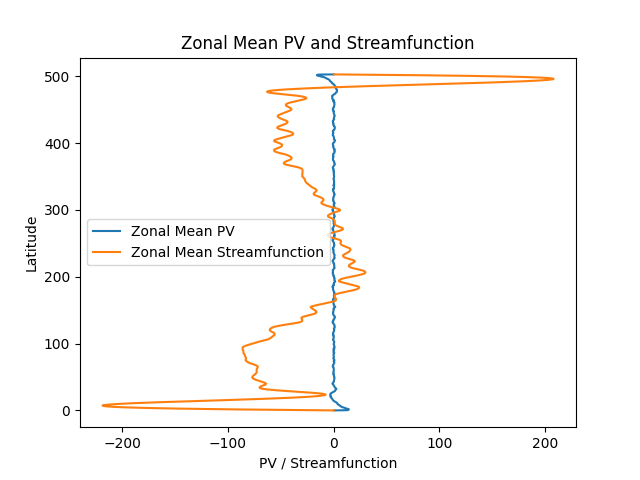

In [97]:


q_zonal_mean = np.mean(q_data, axis=2)  # Averaging over the longitude axis
Psi_zonal_mean = np.mean(psi_data, axis=2)


time_index = -1 # Choose a specific time step to plot

plt.figure()
plt.plot(q_zonal_mean[time_index, :],y,label='Zonal Mean PV')
plt.plot(Psi_zonal_mean[time_index, :],y, label='Zonal Mean Streamfunction')
plt.ylabel('Latitude')
plt.xlabel('PV / Streamfunction')
plt.legend()
plt.title('Zonal Mean PV and Streamfunction')
plt.show()
